In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(ggplot2)
library(BiocIO)
library(genomation)
library(Rsamtools)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    a

Import metadata

In [2]:
meta.hg38 = read.csv("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/geo/cellranger_res/GSE162798_01/outs/per_barcode_metrics.csv",
                     stringsAsFactors = F)
rownames(meta.hg38) = meta.hg38$barcode
meta.mm10 = read.csv("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/geo/cellranger_res/GSE162798_01_mm10/outs/per_barcode_metrics.csv",
                     stringsAsFactors = F)
rownames(meta.mm10) = meta.mm10$barcode

Identify human K562 cells

In [3]:
meta.hg38$gex_mapped_percentage = meta.hg38$gex_mapped_reads / meta.hg38$gex_raw_reads
meta.mm10$gex_mapped_percentage = meta.mm10$gex_mapped_reads / meta.mm10$gex_raw_reads

In [4]:
meta.hg38$atac_mapped_percentage = 1 - meta.hg38$atac_unmapped_reads / meta.hg38$atac_raw_reads
meta.mm10$atac_mapped_percentage = 1 - meta.mm10$atac_unmapped_reads / meta.mm10$atac_raw_reads

In [5]:
bc.qc = union(meta.hg38[meta.hg38$is_cell == 1,"barcode"],
              meta.mm10[meta.mm10$is_cell == 1,"barcode"])

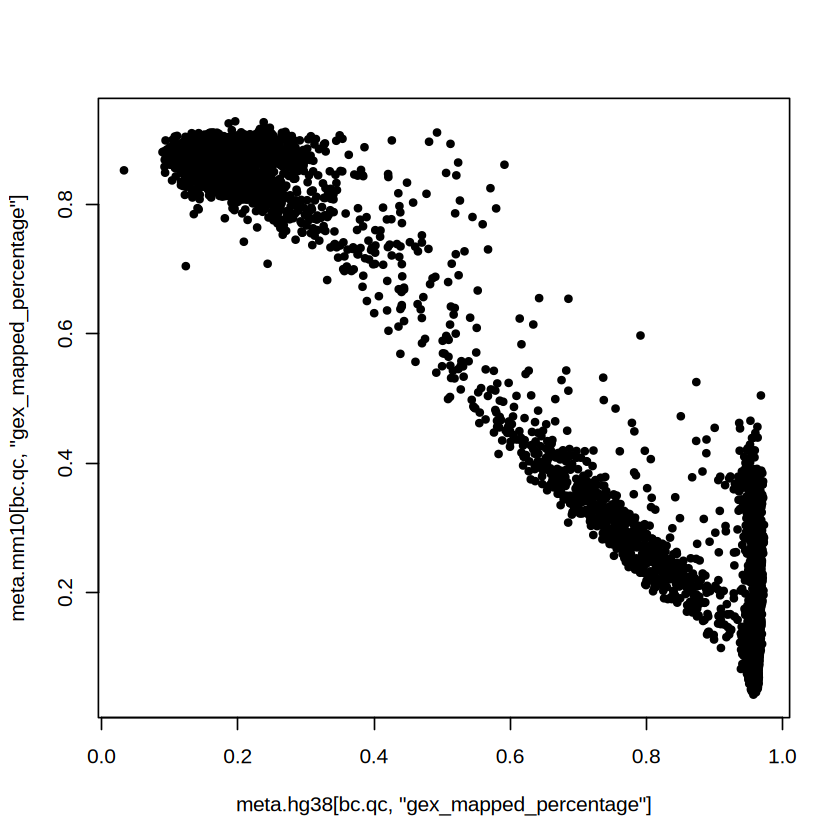

In [6]:
plot(meta.hg38[bc.qc,"gex_mapped_percentage"],
     meta.mm10[bc.qc,"gex_mapped_percentage"],
     pch = 20)

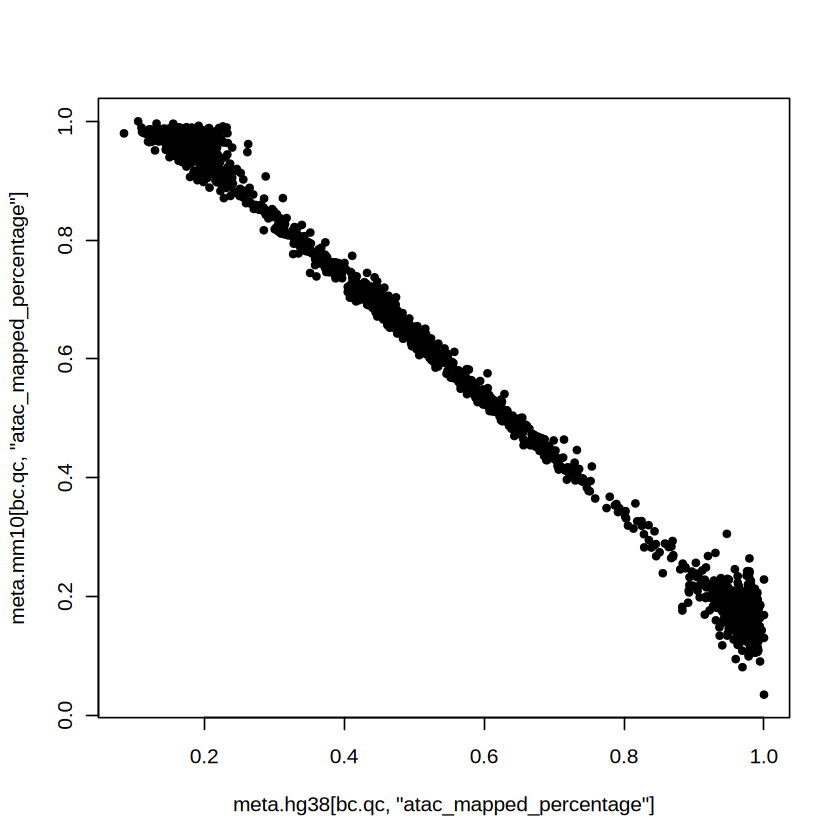

In [7]:
plot(meta.hg38[bc.qc,"atac_mapped_percentage"],
     meta.mm10[bc.qc,"atac_mapped_percentage"],
     pch = 20)


FALSE  TRUE 
 6348  5429 

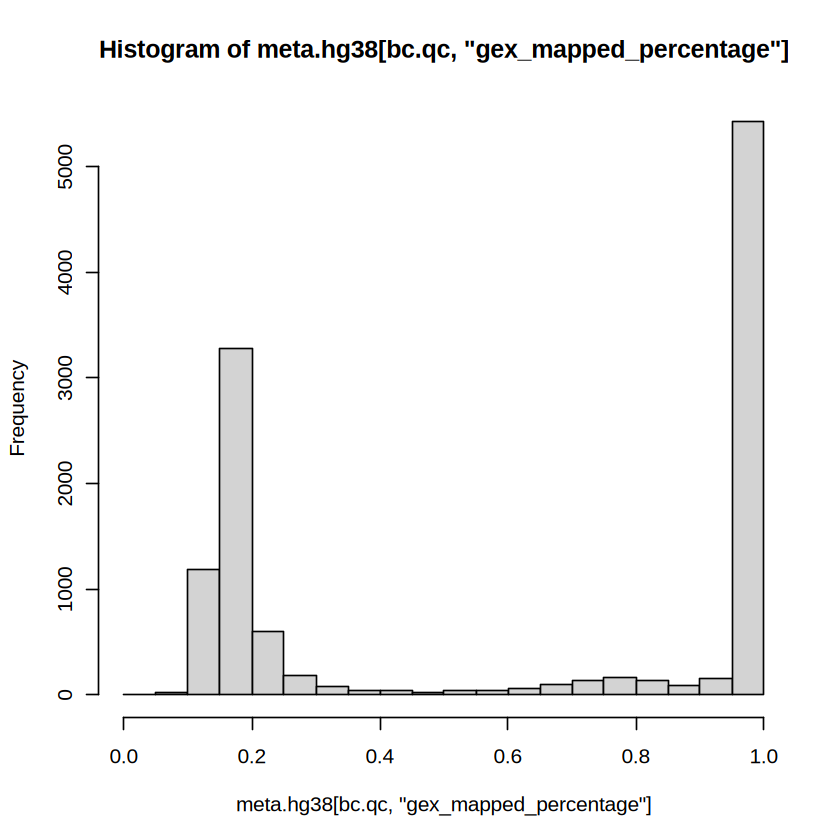

In [8]:
hist(meta.hg38[bc.qc,"gex_mapped_percentage"])
table(meta.hg38[bc.qc,"gex_mapped_percentage"] > 0.95)


FALSE  TRUE 
 6315  5462 

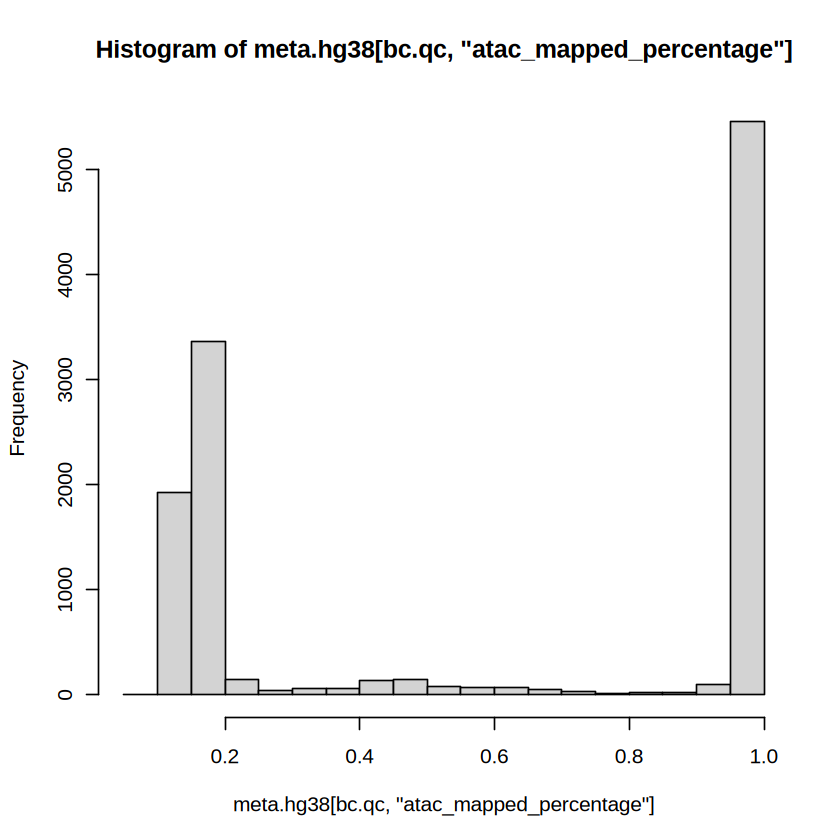

In [9]:
hist(meta.hg38[bc.qc,"atac_mapped_percentage"])
table(meta.hg38[bc.qc,"atac_mapped_percentage"] > 0.95)

In [10]:
bc.qc.gex.hg38 = bc.qc[meta.hg38[bc.qc,"gex_mapped_percentage"] > 0.95]
bc.qc.atac.hg38 = bc.qc[meta.hg38[bc.qc,"atac_mapped_percentage"] > 0.95]
bc.qc.gex_atac.hg38 = intersect(bc.qc.gex.hg38,bc.qc.atac.hg38)

Quality control

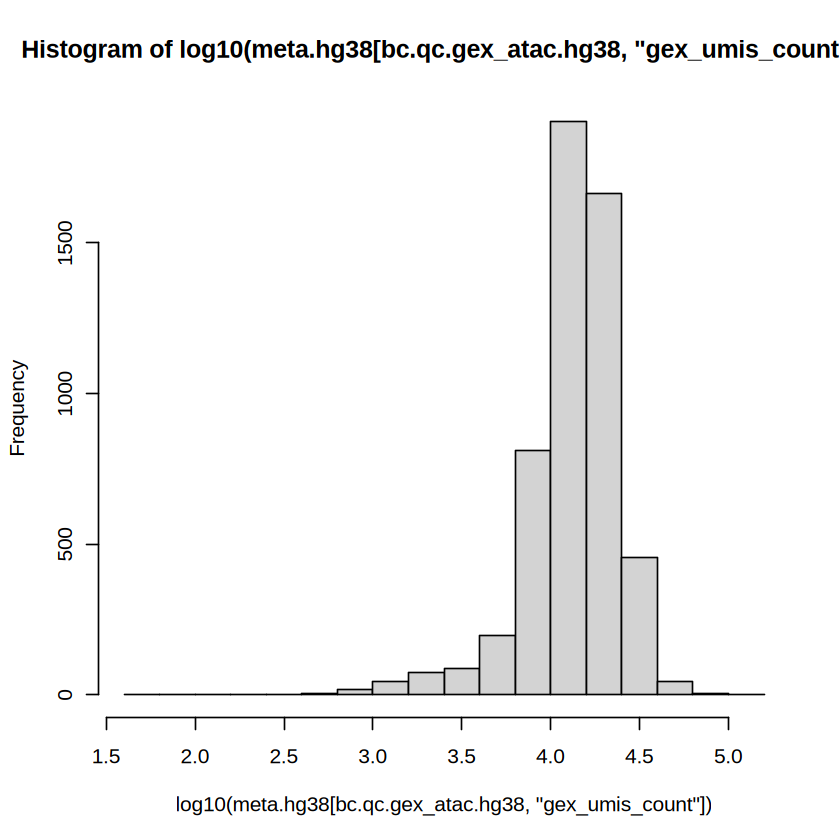

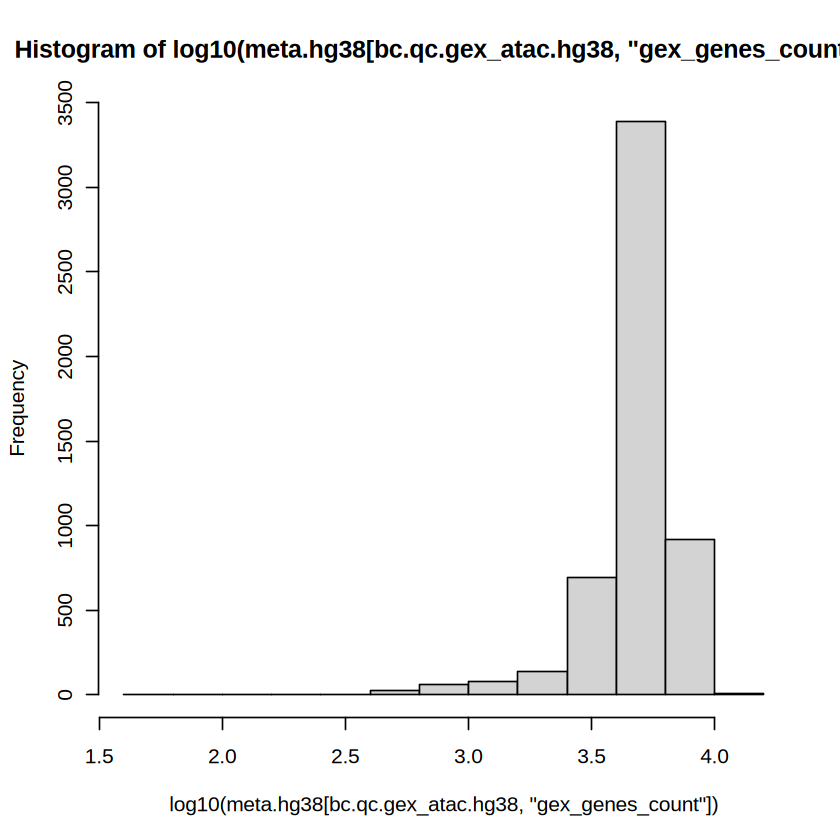

In [11]:
hist(log10(meta.hg38[bc.qc.gex_atac.hg38,"gex_umis_count"]))
hist(log10(meta.hg38[bc.qc.gex_atac.hg38,"gex_genes_count"]))

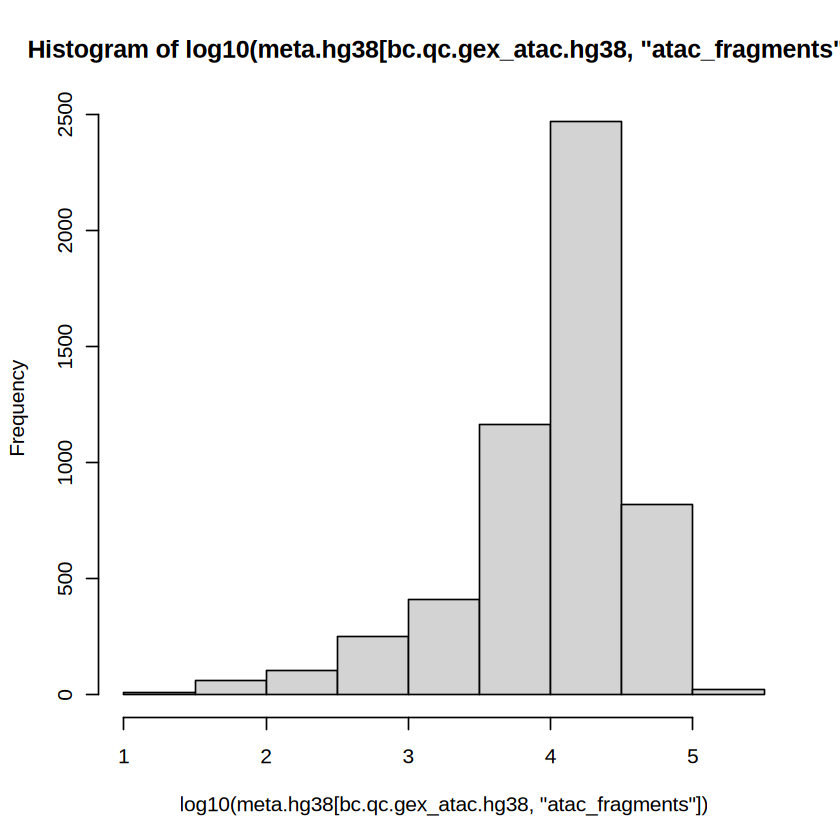

In [12]:
hist(log10(meta.hg38[bc.qc.gex_atac.hg38,"atac_fragments"]))

In [13]:
bc.qc.gex_atac.hg38.gex_filter = bc.qc.gex_atac.hg38[log10(meta.hg38[bc.qc.gex_atac.hg38,"gex_umis_count"]) > 3.8]
bc.qc.gex_atac.hg38.atac_filter = bc.qc.gex_atac.hg38[log10(meta.hg38[bc.qc.gex_atac.hg38,"atac_fragments"]) > 3]
bc.qc.gex_atac.hg38.gex_atac_filter = intersect(bc.qc.gex_atac.hg38.gex_filter,
                                                bc.qc.gex_atac.hg38.atac_filter)

In [14]:
meta.hg38.qc = meta.hg38[bc.qc.gex_atac.hg38.gex_atac_filter,]
meta.hg38.qc$sample = "K562_Wang"
meta.hg38.qc$sample_barcode = paste(meta.hg38.qc$sample,
                                    meta.hg38.qc$barcode,
                                    sep = "_")
rownames(meta.hg38.qc) = meta.hg38.qc$sample_barcode

Import RNA and RNA count matrix

In [15]:
matrix.tmp = Read10X(data.dir = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/geo/cellranger_res/GSE162798_01/outs/raw_feature_bc_matrix/")
matrix.tmp$`Gene Expression` = matrix.tmp$`Gene Expression`[,meta.hg38.qc$barcode]
matrix.tmp$Peaks = matrix.tmp$Peaks[,meta.hg38.qc$barcode]

colnames(matrix.tmp$`Gene Expression`) =
  meta.hg38.qc$sample_barcode
colnames(matrix.tmp$Peaks) =
  meta.hg38.qc$sample_barcode

10X data contains more than one type and is being returned as a list containing matrices of each type.



Create fragment object

In [16]:
list.fragments = list()
cells.tmp = meta.hg38.qc$barcode
names(cells.tmp) = meta.hg38.qc$sample_barcode
list.fragments[[1]] =
  CreateFragmentObject(path = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/geo/cellranger_res/GSE162798_01/outs/atac_fragments.tsv.gz",
                       cells = cells.tmp)

Computing hash



Import geneome annotation

In [17]:
annotation.gtf <- import("/maps/projects/ralab/data/genome/hg38/cellranger_arc/refdata-cellranger-arc-GRCh38-NNFC-2.0.2/genes/genes.gtf.gz", format = "gtf")
mcols(annotation.gtf) = mcols(annotation.gtf)[,c("transcript_id","gene_name","gene_id","gene_type","type")]
colnames(mcols(annotation.gtf)) = c("tx_id", "gene_name", "gene_id", "gene_biotype", "type")

Create seurat object

In [18]:
obj.seurat <- CreateSeuratObject(
  counts = matrix.tmp$`Gene Expression`,
  assay = "RNA",
  meta.data = meta.hg38.qc
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [19]:
obj.seurat[["Peaks"]] <- CreateChromatinAssay(
  counts = matrix.tmp$Peaks,
  fragments = list.fragments,
  annotation = annotation.gtf,
  sep = c(":", "-")
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [20]:
obj.seurat

An object of class Seurat 
268717 features across 4583 samples within 2 assays 
Active assay: RNA (62757 features, 0 variable features)
 1 layer present: counts
 1 other assay present: Peaks

Check ATAC quality

In [21]:
DefaultAssay(obj.seurat) <- "Peaks"
obj.seurat <- NucleosomeSignal(obj.seurat)
obj.seurat <- TSSEnrichment(obj.seurat)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



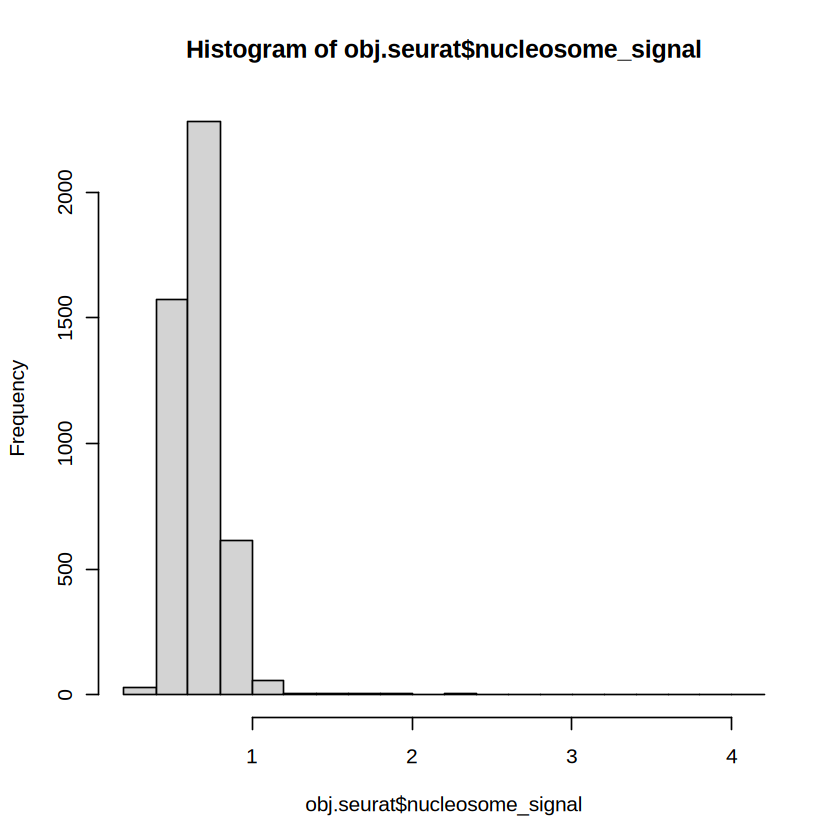

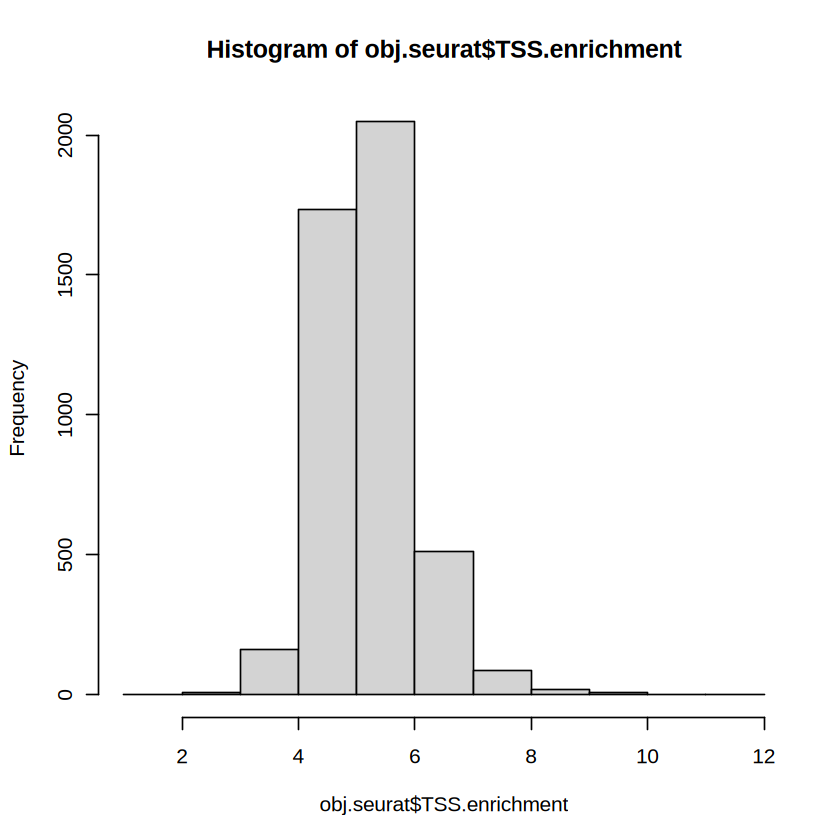

In [22]:
hist(obj.seurat$nucleosome_signal)
hist(obj.seurat$TSS.enrichment)

Filter out low ATAC quality cells

In [23]:
obj.seurat.qc = 
  subset(obj.seurat,
         subset = nucleosome_signal < 2.5 & 
           TSS.enrichment > 2.5)
obj.seurat.qc

An object of class Seurat 
268717 features across 4574 samples within 2 assays 
Active assay: Peaks (205960 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

Plot RNA UMAP

In [24]:
DefaultAssay(obj.seurat.qc) <- "RNA"
obj.seurat.qc <- obj.seurat.qc %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA() %>%
  RunUMAP(dims = 1:30) %>%
  FindNeighbors(dims = 1:30) %>%
  FindClusters()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  FBXL13, AAK1, ASPH, VEGFA, DLGAP1-AS2, SCN9A, GPAT3, VMP1, LINC03000, SCN1A-AS1 
	   TALAM1, HIF1A-AS3, MARCHF3, MGAT5, P4HA1, ENSG00000254180, ARHGAP18, MYO18B, MBNL2, GBE1 
	   ANTXR2, RUNX2, SLC7A11, NIBAN1, SQSTM1, LRP12, CBLB, ACVR1, LINC00534, STXBP5 
Negative:  MT-ATP6, MT-CO3, MT-CYB, MT-ND3, MTATP6P1, MT-ND2, PTMA, MT-ND4, HSP90AA1, MT-ATP8 
	   HSP90AB1, MT-ND4L, MT-ND5, MT-ND1, HSPA8, NCL, CENPF, KCNH2, GAL, ENSG00000289474 
	   HBG1, TOP2A, SPN, SNHG3, NMU, LINC01029, MT-ND6, ASPM, LINC03021.1, HBG2 
PC_ 2 
Positive:  MT-ND4, MT-ND1, MT-ND5, MT-CYB, MT-ND3, MT-CO3, MT-ND2, HSP90AB1, CALR, MT-ND4L 
	   MT-ATP6, SDF2L1, MT-ATP8, MTATP6P1, HSP90B1, ENSG00000289474, HSPA5, HBG1, FTH1, HSPA8 
	   MT-ND6, PTMA, ACTG1, APOE, NCL, ABHD5, RNASET2, HSP90AA1, TYROBP, ALAS2 
Negative:  KIF14, KIF18B, PIF1, CDCA2, CDC25C, KIF18A, NDC80, KIF4A, ASPM, DEPDC1B 
	   CD

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4574
Number of edges: 164519

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7419
Number of communities: 10
Elapsed time: 0 seconds


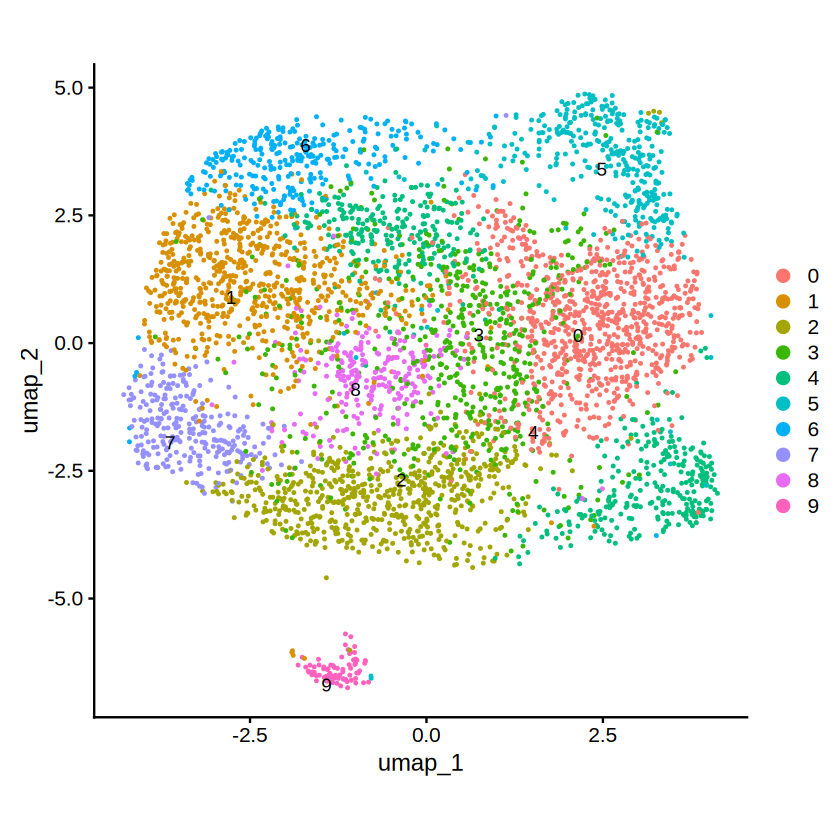

In [25]:
DimPlot(obj.seurat.qc, label = TRUE, repel = TRUE, reduction = "umap")  +
  theme(aspect.ratio=1)

Plot ATAC UMAP

In [26]:
DefaultAssay(obj.seurat.qc) <- "Peaks"
obj.seurat.qc <- obj.seurat.qc %>%
  RunTFIDF() %>%
  FindTopFeatures(min.cutoff = 'q0') %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30) %>%
  FindNeighbors(reduction = 'lsi', dims = 2:30) %>%
  FindClusters(verbose = FALSE, algorithm = 3)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings

12:49:38 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:49:38 Read 4574 rows and found 29 numeric columns

12:49:38 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:49:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:49:38 Writing NN index file to temp file /tmp/RtmpYmxEtC/file2568206582da6d

12:49:38 Searching Annoy index using

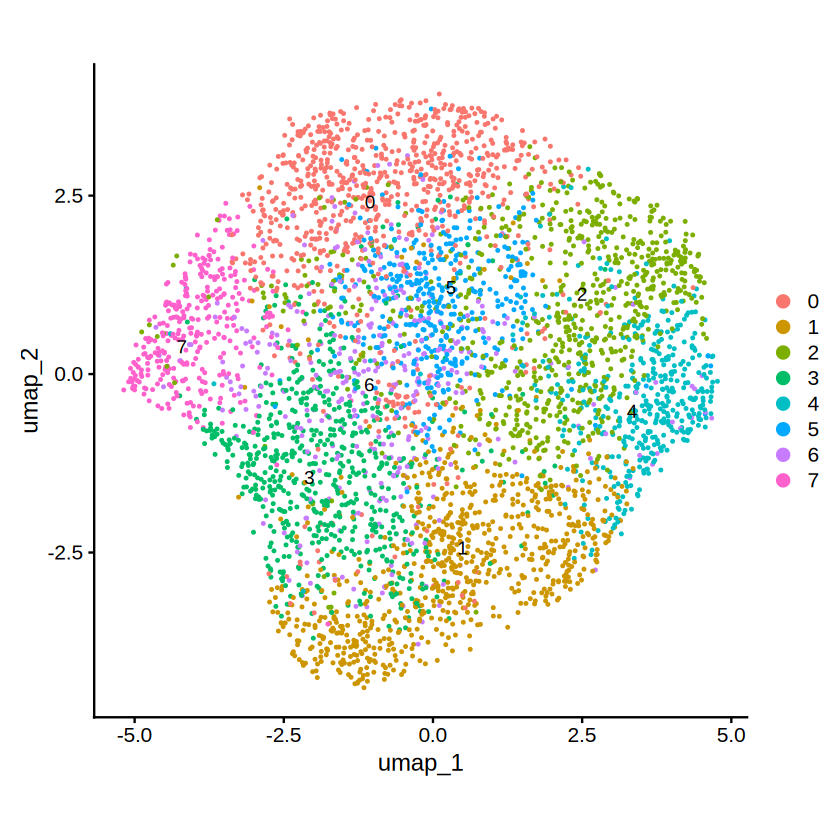

In [27]:
DimPlot(obj.seurat.qc, label = TRUE, repel = TRUE, reduction = "umap")  +
  theme(aspect.ratio=1)

Output fragment file for cells passing qc

In [28]:
atac_fragments = read.delim("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/geo/cellranger_res/GSE162798_01/outs/atac_fragments.tsv.gz",
                            header = F,
                            comment.char = "#")

In [29]:
atac_fragments.filter = 
  atac_fragments[atac_fragments$V4 %in% obj.seurat.qc$barcode,]
atac_fragments.filter = 
  atac_fragments.filter[atac_fragments.filter$V1 %in% paste("chr",c(1:22,"X","Y"), sep = ""),]
atac_fragments.filter[,4] = paste("K562_Wang",atac_fragments.filter[,4],sep = "_")
atac_fragments.filter

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<int>
6,chr1,10078,10334,K562_Wang_GTGGCTTCATAAAGCA-1,1
8,chr1,10084,10279,K562_Wang_GGTTACCCACAGGAAT-1,2
10,chr1,10085,10309,K562_Wang_TCCTCAATCCTAATGA-1,2
13,chr1,10090,10284,K562_Wang_CTGTTAAAGTAGCGGG-1,4
14,chr1,10091,10284,K562_Wang_GCCATTACATCCTGAA-1,1
16,chr1,10096,10497,K562_Wang_CTCCTGAGTGACCTGG-1,2
17,chr1,10097,10345,K562_Wang_TTGACTAAGGCAGGTG-1,2
41,chr1,10151,10180,K562_Wang_CATCACACAGGTTCAC-1,1
43,chr1,10151,10180,K562_Wang_CGTGTTACAGCAAGGC-1,1


In [31]:
write.table(atac_fragments.filter,
            "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv",
            col.names = F,
            row.names = F,
            quote = F,
            sep = "\t")
bgzip("../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv",
      "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv.gz",
     overwrite = T)


indexTabix("../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv.gz",
           format = "bed")

system("../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv")

[1] "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv.gz"

[1] "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv.gz.tbi"

Output RNA count matrix file for cells passing qc

In [32]:
write.csv(as.data.frame(obj.seurat.qc@assays$RNA$count),
          "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/rna_count_matrix.csv.gz",
          quote = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.1 GiB”


Save obj.seurat.qc

In [33]:
saveRDS(obj.seurat.qc,
         "../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/obj.seurat.qc.rds")

In [34]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.9 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Rsamtools_2.18.0     Biostrings_2.70.1    XVector_0.42.0      
 [4] GenomicRanges_1.54.1 GenomeInfoDb_1.38.1  IRanges_2.36.0      

In [2]:
obj.seurat.qc = readRDS("../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/obj.seurat.qc.rds")

In [3]:
write.csv(t(as.data.frame(obj.seurat.qc@assays$RNA$count)),
          gzfile("../../../data/K562_Wang/1.prepare_data/1.seurat_pipeline.240507/rna_count_matrix.t.csv.gz"),
          quote = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.1 GiB”
